# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

Required dependencies.

In [1]:
import os
import sys 
import json
import torch
import platform
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader

In [2]:
# Check is at least python 3.9
assert (sys.version_info.major == 3) and (sys.version_info.minor > 9)

# Get os name
os_name = platform.system().lower()

# OS X
if 'darwin' in os_name:
    num_workers = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Set the device to mps (Apple Silicon GPU) if availaible for faster computation
    print("Detected OS X, device set to:", device)
# Linux 
elif 'linux' in os_name:
    device = torch.device("cpu")
    num_workers = 8
    print("Detected Linux, device set to:", device) 
# Windows 
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 0
    print("Detected Windows, device set to:", device)

Detected OS X, device set to: mps


## Load the image captioning dataset

Let's load the images, with their labels and caption.

In [3]:
def load_data(json_path, list, img_path):

    image_paths, texts, labels = [], [], []

    with open(json_path, 'r') as f:
        # Iterate over the lines in the file
        for line in f:
            # Load the JSON object from the line
            obj = json.loads(line)
            image_paths.append(os.path.join(img_path, obj['id'] + '.png'))

            texts.append(obj['text'])
            labels.append(obj['label'])
    images=[Image.open(img) for img in image_paths]

    for image, image_path, text, label in zip(images, image_paths, texts, labels):
        item = {"image": image, "image_path": image_path, "text": text, "label": label}
        list.append(item)

    print(f"Loaded {len(list)} memes from {json_path[17:]}")

In [4]:
topics = ['Base', 'Africans', 'Womens', 'Muslims']
img_path  = '../hateful_memes/img'

train_list_B = []
validation_list_B = []
test_list_B = []
train_list_W = []
validation_list_W = []
test_list_W = []
train_list_A = []
validation_list_A = []
test_list_A = []
train_list_M = []
validation_list_M = []
test_list_M = []

for topic in topics: 
    train_json_path = f'../hateful_memes/{topic}_train.jsonl'
    validation_json_path = f'../hateful_memes/{topic}_val.jsonl'
    test_json_path = f'../hateful_memes/{topic}_test.jsonl'

    # Get the first letter of the topic
    topic_initial = topic[0]

    # Use locals to access the correct list based on the topic
    load_data(train_json_path, locals()[f'train_list_{topic_initial}'], img_path)
    load_data(validation_json_path, locals()[f'validation_list_{topic_initial}'], img_path)
    load_data(test_json_path, locals()[f'test_list_{topic_initial}'], img_path)

Loaded 2414 memes from Base_train.jsonl
Loaded 604 memes from Base_val.jsonl
Loaded 504 memes from Base_test.jsonl
Loaded 1100 memes from Africans_train.jsonl
Loaded 276 memes from Africans_val.jsonl
Loaded 208 memes from Africans_test.jsonl
Loaded 838 memes from Womens_train.jsonl
Loaded 210 memes from Womens_val.jsonl
Loaded 204 memes from Womens_test.jsonl
Loaded 716 memes from Muslims_train.jsonl
Loaded 180 memes from Muslims_val.jsonl
Loaded 122 memes from Muslims_test.jsonl


Let's retrieve the caption and the corresponding image for each of our 3 topics:

Topic: Base - Caption: when a girl says she is lesbian so you become trans to smash modern problems require modern solutions - Label: 1
Topic: Africans - Caption: jamal! im pregnant!!! - Label: 0
Topic: Womens - Caption: there are 33 genders man, woman, and 31 types of queer - Label: 0
Topic: Muslims - Caption: when you're trying to listen to the teacher in your school and the foreign exchange student keeps on crying - Label: 0


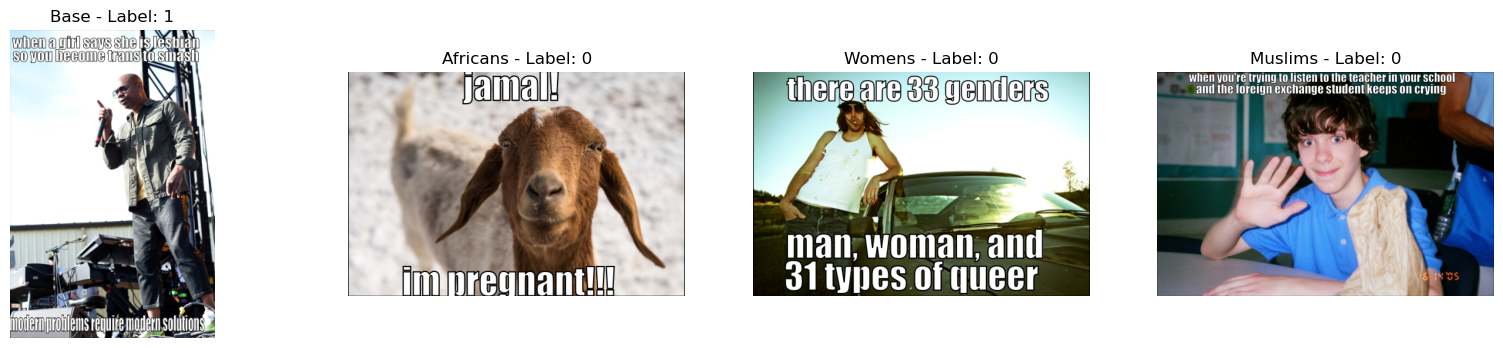

In [5]:
fig, axs = plt.subplots(1, len(topics), figsize=(20, 4))

for i, topic in enumerate(topics): 
    topic_initial = topic[0]
    print(f"Topic: {topic} - Caption: {locals()[f'train_list_{topic_initial}'][0]["text"]} - Label: {locals()[f'train_list_{topic_initial}'][0]["label"]}")
    axs[i].imshow(locals()[f'train_list_{topic_initial}'][0]["image"])
    axs[i].set_title(f"{topic} - Label: {locals()[f'train_list_{topic_initial}'][0]['label']}")
    axs[i].axis('off')

plt.show()

## Create PyTorch Dataset

Custom Dataset class

In [6]:
from utils import Config
from modeling_frcnn import GeneralizedRCNN
from processing_image import Preprocess

class ImageProcessor:
    def __init__(self, device):
        frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        frcnn_cfg.MODEL.DEVICE = device
        self.device = device

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

        self.frcnn_cfg = frcnn_cfg
        self.image_preprocess = Preprocess(frcnn_cfg)

    def get_visual_embeddings(self, image_path):
        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(image_path)

        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections=self.frcnn_cfg.max_detections,
            return_tensors="pt",
        )
        features = output_dict.get("roi_features").detach().cpu()
        return features

In [7]:
from transformers import VisualBertModel, BertTokenizer

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir="cache")

        # tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
        # tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        # processor = AutoProcessor.from_pretrained("microsoft/beit-base-patch16-224")
        self.visual_extractor = ImageProcessor(device=device)

        # self.base_path = base_path
        # self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]
        image = item["image_path"]
        text = item["text"]
        label = item["label"]

        # Process the image
        visual_embeds = self.visual_extractor.get_visual_embeddings(image)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

        # Process the text
        # title_text, title_text_length = self.preprocess_text(title_text)
        # ocr_text, ocr_text_length = self.preprocess_text(ocr_text)
        # text = f'title: {title_text} body: {ocr_text}'
        inputs = self.tokenizer(text, return_tensors="pt")
        # processed_text = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        input_ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        attention_mask = inputs["attention_mask"]

        # Process the label
        label = torch.tensor(label).long()

        return (input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, label)

## Load model and processor

In [8]:
class VBERTForClassification(nn.Module):
    def __init__(self, vbert_model):
        super(VBERTForClassification, self).__init__()
        self.vbert = vbert_model
        self.classifier = nn.Linear(self.vbert.config.hidden_size, 2)  # Assuming binary classification
        self.loss_fn = nn.CrossEntropyLoss()  # Loss function for classification

    def forward(self, input_ids, pixel_values, attention_mask=None, labels=None):
        outputs = self.vbert(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        text_embeds = outputs.text_embeds
        image_embeds = outputs.image_embeds
        combined_embeds = text_embeds + image_embeds  # Combining embeddings; you can choose a different strategy

        logits = self.classifier(combined_embeds)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        return logits, loss

In [9]:
topics = ['Muslims']
# topics = ['Base', 'Africans', 'Womens', 'Muslims']

model_B = None
model_W = None
model_A = None
model_M = None

# Create 4 Visual BERT models, one for each topic +1 base model
for topic in topics :

    topic_initial = topic[0]

    # Create a base VBERT model
    locals()[f'model_{topic_initial}'] = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

    # Freeze all parameters in the VBERT model
    for param in locals()[f'model_{topic_initial}'].parameters():
        param.requires_grad = False

    # Add the classification head
    locals()[f'model_{topic_initial}'] = VBERTForClassification(locals()[f'model_{topic_initial}'])

    # Unfreeze the classification head
    for param in locals()[f'model_{topic_initial}'].classifier.parameters():
        param.requires_grad = True
    
    print(f"Succesfully created model_{topic_initial}.")

Succesfully created model_M.


Compute model size and display model architecture

In [10]:
save = False
if save:
    # Save the model paramters to estimate the size of the model: CLIP = 605 MB, BLIP = X MB, VBert = 445 MB
    torch.save(model_M.state_dict(), "VBERT_size.pth")
    # Display the model summary
    #(C, H, W): number of channels (C), height (H), and width (W) of the input image.
    # input_size = (3, 224, 224) 
    # summary(model_B, input_size)

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [11]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    input_ids = pad_sequence([item[0].squeeze(0) for item in batch], batch_first=True, padding_value=0)
    token_type_ids = pad_sequence([item[1].squeeze(0) for item in batch], batch_first=True, padding_value=0)
    attention_mask = pad_sequence([item[2].squeeze(0) for item in batch], batch_first=True, padding_value=0)
    
    visual_embeds = torch.stack([item[3] for item in batch])
    visual_token_type_ids = torch.stack([item[4] for item in batch])
    visual_attention_mask = torch.stack([item[5] for item in batch])
    labels = torch.stack([item[6] for item in batch])
    
    return (input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels)

In [12]:
train_loader_B = None
validation_loader_B = None
test_loader_B = None

train_loader_W = None
validation_loader_W = None
test_loader_W = None

train_loader_A = None
validation_loader_A = None
test_loader_A = None

train_loader_M = None
validation_loader_M = None
test_loader_M = None

for topic in topics:
    
    topic_initial = topic[0]

    # Build the train and validation datasets
    train_dataset      = ImageCaptioningDataset(locals()[f'train_list_{topic_initial}'], device=device)
    validation_dataset = ImageCaptioningDataset(locals()[f'validation_list_{topic_initial}'], device=device)
    test_dataset       = ImageCaptioningDataset(locals()[f'test_list_{topic_initial}'], device=device)

    # Create loaders
    locals()[f'train_loader_{topic_initial}'] = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=num_workers, collate_fn=collate_fn)
    locals()[f'validation_loader_{topic_initial}'] = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    locals()[f'test_loader_{topic_initial}'] = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

    print(f"Succesfully created loaders for model_{topic_initial}.")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /Users/theoh/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /Users/theoh/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used w

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [13]:
@torch.no_grad()
def test(model : nn.Module, loader : DataLoader, device : torch.device):
    """The test function, computes the F1 score of the current model on the test_loader

    Args:
        model (nn.Module): The model to evaluate
        test_loader (DataLoader): The test data loader to iterate on the dataset to test

    Returns:
        f1 (float): The F1 score on the given dataset
        loss (float): Averaged loss on the given dataset
    """
    model.eval()

    preds_dict = {"preds" : torch.Tensor(), "labels" : torch.Tensor(), 'losses': torch.Tensor()}
    for batch in loader:
        images, texts, labels = batch
        images = images.squeeze(1).to(device)
        texts = {key: value.to(device) for key, value in texts.items()}
        labels = labels.to(device)
        # Forward and loss
        preds, _ = model(pixel_values=images, input_ids=texts["input_ids"], attention_mask=texts["attention_mask"])
        loss = F.cross_entropy(preds, labels)
        
        # Store values back to the CPU before storing them in preds_dict. This is because PyTorch tensors on the GPU cannot be converted to NumPy arrays, which is what f1_score requires.
        preds_dict["preds"] = torch.cat([preds_dict["preds"], preds.argmax(1).cpu()])
        preds_dict["labels"] = torch.cat([preds_dict["labels"], labels.cpu()])
        preds_dict["losses"] = torch.cat([preds_dict["losses"], loss[None].cpu()])

    # Compute metric and loss
    f1 = f1_score(preds_dict["labels"], preds_dict["preds"], average="macro")
    loss = preds_dict["losses"].mean()

    return f1, loss

In [14]:
def train(model : nn.Module, train_loader : DataLoader, val_loader : DataLoader, n_epochs : int, optimizer : torch.optim.Optimizer, device : torch.device, scheduler = None):
    """Trains the neural network self.model for n_epochs using a given optimizer on the training dataset.
    Outputs the best model in terms of F1 score on the validation dataset.

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): The training dataloader to iterate on the training dataset
        val_loader (DataLoader): The validation dataloader to iterate on the validation dataset
        n_epochs (int): The number of epochs, i.e. the number of time the model should see each training example
        optimizer (torch.optim.Optimizer): The optimizer function to update the model parameters

    Returns:
        best_model (nn.Module): Best model state dictionary 
        best_f1 (float): Best F1-score on the validation set
        best_epoch (int): Best epoch on validation set
        val_f1s (list of floats): (n_epochs, ) F1-scores for all epochs
        val_losses (list of floats): (n_epochs, ) Losses for all validation epochs
        train_losses(list of floats): (n_epochs, ) Losses for all training epochs
    """

    # Initialize variable to return
    best_model = model.state_dict()
    best_epoch = 0
    best_f1 = 0
    train_losses = []
    val_losses = []
    val_f1s = []
    f1 = 0
    val_loss = 0

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            (input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, train_labels) = batch

            inputs = {
                "input_ids": input_ids.to(device),
                "attention_mask": attention_mask.to(device),
                "visual_embeds": visual_embeds.to(device),
                "token_type_ids": token_type_ids.to(device),
                "visual_token_type_ids": visual_token_type_ids.to(device),
                "labels": train_labels.to(device)
            }

            outputs = model(**inputs)
            loss = F.cross_entropy(outputs.logits, train_labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        with torch.no_grad():
            model.eval()
            f1, val_loss = test(model, val_loader, device)
            val_f1s.append(f1)
            val_losses.append(val_loss)

            if scheduler:
                scheduler.step(val_loss)
                current_lr = scheduler.optimizer.param_groups[0]['lr']
            else:
                current_lr = optimizer.param_groups[0]['lr']

            if f1 > best_f1: 
                best_model = model.state_dict()
                best_f1 = f1
                best_epoch = epoch + 1

        print(f'Epoch {epoch + 1} - F1: {f1:.3f} - Validation Loss: {val_loss:.3f} - Training Loss: {running_loss / len(train_loader):.3f} - LR: {current_lr:.6f}')

    return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

In [15]:
training_active = True

try:
    for topic in topics:
        topic_initial = topic[0]
        if training_active:

            locals()[f'model_{topic_initial}'].train()
            locals()[f'model_{topic_initial}'].to(device)

            optimizer = torch.optim.AdamW(locals()[f'model_{topic_initial}'].parameters(), lr=5e-4)

            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=2)

            epochs = 5

            print(f"Training model_{topic_initial} for {epochs} epochs...")
            # Run training and display results:
            best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = train(locals()[f'model_{topic_initial}'], locals()[f'train_loader_{topic_initial}'], locals()[f'validation_loader_{topic_initial}'], n_epochs=epochs, optimizer=optimizer, device=device, scheduler=scheduler)
            print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

            # Save the state dictionary
            torch.save(best_model, f'VBERT_{topic_initial}_trained.pth')

            locals()[f'model_{topic_initial}'] = locals()[f'model_{topic_initial}'].to(device)  # Move the model to the device
            locals()[f'model_{topic_initial}'].eval();  # Set the model to evaluation mode

        else:
            # Check if the file exists before trying to load it
            if os.path.exists(f'CLIP_{topic_initial}_trained.pth'):
                locals()[f'model_{topic_initial}'] = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre") # Create a new model
                locals()[f'model_{topic_initial}'] = VBERTForClassification(locals()[f'model_{topic_initial}'])         # Add the classification head
                locals()[f'model_{topic_initial}'].load_state_dict(torch.load(f'VBERT_{topic_initial}_trained.pth'))    # Load the state_dict
                locals()[f'model_{topic_initial}'] = locals()[f'model_{topic_initial}'].to(device)                      # Move the model to the device
                locals()[f'model_{topic_initial}'].eval();                                                              # Set the model to evaluation mode
                locals()[f'model_{topic_initial}'].to(device)                                                           # Move the model to the device
                print(f"Succesfully loaded saved weights for model_{topic_initial}.")
            else:
                print(f"No pre-trained model found for model_{topic_initial}.")
                locals()[f'model_{topic_initial}'] = None
except KeyboardInterrupt:
    print("Training interrupted. Saving model and outputs...")
    # Save the state dictionary
    torch.save(best_model, f'CLIP_{topic_initial}_trained.pth')
    locals()[f'model_{topic_initial}'] = locals()[f'model_{topic_initial}'].to(device)  # Move the model to the device
    locals()[f'model_{topic_initial}'].eval();  # Set the model to evaluation mode

Training model_M for 5 epochs...


/Users/theoh/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226120/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TypeError: VBERTForClassification.forward() got an unexpected keyword argument 'visual_embeds'

In [ ]:
def plot_training(best_epoch: int, val_accs: list, val_loss: list, train_loss: list):
    """Plot training results of linear classifier
    
    Args:
        best_epoch (int): Best epoch
        val_accs (List): (E,) list of validation measures for each epoch
        val_loss (List): (E,) List of validation losses for each epoch
        train_loss (List): (E,) List of training losses for each epoch
    """

    # Create plot
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    es = np.arange(1, len(val_accs)+1)
    # Plot F1 score
    axes[0].plot(es, val_accs, label="Val")
    axes[0].vlines(best_epoch, ymin=np.min(val_accs), ymax=np.max(val_accs), color='k', ls='--', label="Best epoch")
    axes[0].set_xlabel("Training steps")
    axes[0].set_ylabel("F1-score")
    axes[0].set_title("F1-score")
    axes[0].legend()

    # Plot losses
    axes[1].plot(es, val_loss, label="Val")
    axes[1].plot(es, train_loss, label="Train")
    axes[1].vlines(best_epoch, ymin=np.min(train_loss), ymax=np.max(val_loss), color='k', ls='--', label="Best epoch")
    axes[1].set_xlabel("Training steps")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Losses")
    axes[1].legend()
    
    plt.tight_layout()

# Plot results
# for topic in topics:
#     if training_active:
#         plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)

## Inference

Let's check the results on our validation set:

In [ ]:
for topic in topics:
    topic_initial = topic[0]
    # check that the model is loaded correctly
    if locals()[f'model_{topic_initial}'] is not None:
        print(f"Model_{topic_initial} F1 score on the training set: {test(locals()[f'model_{topic_initial}'], locals()[f'train_loader_{topic_initial}'], device)[0]:.3f}")
        print(f"Model_{topic_initial} F1 score on the validation set: {test(locals()[f'model_{topic_initial}'], locals()[f'validation_loader_{topic_initial}'], device)[0]:.3f}")
        print(f"Model_{topic_initial} F1 score on the testing set: {test(locals()[f'model_{topic_initial}'], locals()[f'test_loader_{topic_initial}'], device)[0]:.3f}")

In [ ]:
def predict_image(model: nn.Module, loader: DataLoader, device: torch.device, index: int, show: bool = True):

    model.eval()
    
    # Only process the first batch
    for batch in loader:
        images, texts, labels = batch
        images = images.squeeze(1).to(device)
        texts = {key: value.to(device) for key, value in texts.items()}
        labels = labels.to(device)
        
        # Forward and loss
        preds, _ = model(pixel_values=images, input_ids=texts["input_ids"], attention_mask=texts["attention_mask"])

        true_label = labels[index].item()
        predicted_label = preds.argmax(1)[index].item()

        if show:
            # Plot the specified image, its prediction, and the true label
            image = images[index].cpu().numpy().transpose(1, 2, 0)  # Assuming images are in (C, H, W) format
            # Ensure image is in the correct range
            image = np.clip(image, 0, 1)

            plt.imshow(image)
            plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
            plt.axis('off')
            plt.show()
        
        break  # Exit after processing the first batch

# Predict an image
for topic in topics:
    topic_initial = topic[0]
    if locals()[f'model_{topic_initial}'] is not None:
        predict_image(locals()[f'model_{topic_initial}'], locals()[f'test_loader_{topic_initial}'], device, index=0)